
# Challenges of variational quantum optimization in presence of measurement shot noise
G. Scriva, N. Astrakhantsev, S. Pilati, G. Mazzola

---

Here we show an interactive notebook with all the figures in the papers.  

In [3]:
import itertools
import os
import math

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

Set matplotlib's hyperparameters.

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

Define the saling functions.

In [5]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

Load the datasets:

1. Ferromagnetic model both for VQE and QAOA with random parameters initialization;
2. Ferromagnetic model for VQE with with random parameters initialization and circuit noise;
3. Disordered model both for VQE and QAOA with random parameters initialization;
4. Ferromagnetic model for QAOA with annealing-like parameters initialization;
5. Disordered model for QAOA with annealing-like parameters initialization.
6. Ferromagnetic model for VQE with gradient-based parameters initialization;
7. Ferromagnetic model for QAOA with gradient-based parameters initialization;


In [6]:
ferro_df = pd.read_csv("dataferro.csv", index_col=0)
noise_df = pd.read_csv("datanoise.csv", index_col=0)
spinglass_df = pd.read_csv("data_spinglass.csv", index_col=0)
data_linopt = pd.read_csv("data_linopt.csv", index_col=0)
data_linopt_rand = pd.read_csv("data_lininit_rand.csv", index_col=0)
data_grad = pd.read_csv(f"datagrad.csv", index_col=0)
datagrad_eps05 = pd.read_csv(f"datagrad_eps05.csv", index_col=0)


## Figure 2



/tmp/ipykernel_195593/2394904418.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  inplot.set_xticklabels([r"$2.5 \cdot 10^4$", r"$10^5$", r"$2 \cdot 10^5$", r"$3 \cdot 10^5$"], fontsize="small")
/tmp/ipykernel_195593/2394904418.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  inplot.set_yticklabels([0.75, 0.8, 0.9, 1.0], fontsize="small")


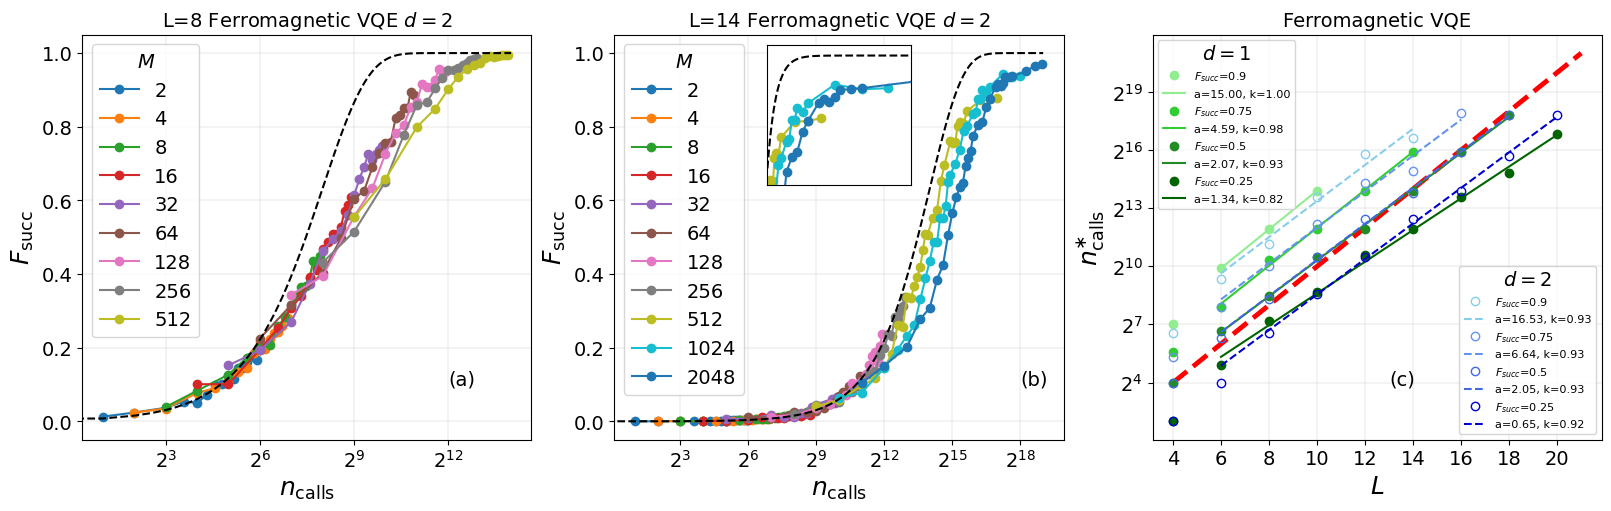

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,3)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):
    if i == 0:
        qubits = 8
        depth = 2
        max_shots = 1024
        algo = 'vqe'
        for shot, data in ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits) & (ferro_df['shots'] < max_shots)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(6+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(6+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"VQE $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$')

        subplot.text(2**12, 0.1, '(a)')

    if i == 1:
        qubits = 14
        depth = 2
        algo = 'vqe'

        inplot = fig.add_axes([.476, .64, .09, .28])
        xmin, xmax = 25000,300000
        ymin, ymax = 0.75, 1.02

        for shot, data in ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")
            inplot.plot(x_axes, y_axes, "-o")


        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"VQE $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$')
        
        inplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")

        inplot.set_xlim(xmin, xmax)
        inplot.set_ylim(ymin, ymax)

        subplot.grid(linewidth = 0.2)

        inplot.set_xticklabels([r"$2.5 \cdot 10^4$", r"$10^5$", r"$2 \cdot 10^5$", r"$3 \cdot 10^5$"], fontsize="small")
        inplot.set_yticklabels([0.75, 0.8, 0.9, 1.0], fontsize="small")
        inplot.tick_params(  
            axis='both',   # changes apply to both axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left = False,
            right=False,
            labelleft=False,
            labelbottom=False,
        )

        subplot.text(2**18, 0.1, '(b)')

    if i == 2:
        min_qubits, max_qubits = 4, 20
        min_qubits_toplot, max_qubits_toplot = 6, 22
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

        depth1 = 1
        depth2 = 2
        algo = 'vqe' 

        subplot.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        plots1, plots2 = [], []

        p_tresholds = [0.90, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth1) & (ferro_df['qubits'] >= min_qubits)]
            data2 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth2) & (ferro_df['qubits'] >= min_qubits)]
            
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][1:], np.log2(gt_p1['t'][1:]))
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)

            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][2:], np.log2(gt_p2['t'][2:]))
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        first_legend = subplot.legend(handles=plots1, title=r"$d=$"+f"{depth1}", loc='upper left', fontsize="xx-small")
        ax = subplot.add_artist(first_legend)

        subplot.grid(linewidth = 0.2)

        subplot.legend(handles=plots2, loc='lower right', title=r"$d=$"+f"{depth2}", fontsize="xx-small")

        subplot.set_title("Ferromagnetic " + r"VQE", fontsize=14)

        subplot.text(13, 2**3.9, '(c)')

plt.savefig("img/fig2.png", dpi=300)


## Figure 3


In [9]:
depth1 = 2
depth2 = 2

algo = 'vqe' 

/tmp/ipykernel_119251/796510297.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*data1.loc[:,'qubits']*depth1 #vqe
/tmp/ipykernel_119251/796510297.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*data1.loc[:,'qubits']*depth1 #vqe
/tmp/ipykernel_119251/796510297.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

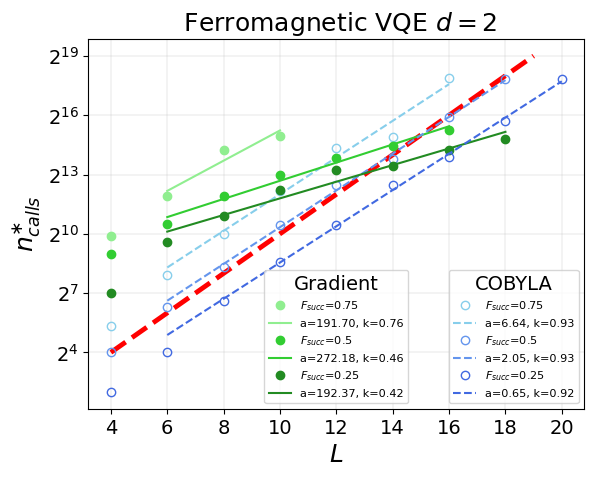

In [10]:
fig, ax = plt.subplots()

min_qubits, max_qubits = 4, 20
min_qubits_toplot, max_qubits_toplot = 4, 20
qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

ax.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

plots1, plots2 = [], []

p_tresholds = [0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for j, (p, color) in enumerate(zip(p_tresholds, colors)):
    data1 = data_grad[(data_grad['algo'] == algo) & (data_grad['circ_depth'] == depth1) & (data_grad['qubits'] >= min_qubits) & (data_grad['qubits'] <= max_qubits)]
    data2 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth2) & (ferro_df['qubits'] >= min_qubits) ]

    # update t for gradient
    if algo == "vqe":
        data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*data1.loc[:,'qubits']*depth1 #vqe
    elif algo == "qaoa": 
        data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*depth1 #qaoa
    else:
        print(f"Not implemented algo {algo}")
        break
    
    gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
    gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    plot1, = ax.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
    plots1.append(plot1)
    if p!=0.9:
        popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][1:], np.log2(gt_p1['t'])[1:])
        plot1, = ax.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
    else:
        popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'], np.log2(gt_p1['t']))
        plot1, = ax.plot(gt_p1['qubits'], fun_exp(gt_p1['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
    plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][2:], np.log2(gt_p2['t'])[2:])
    plot2, = ax.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
    plots2.append(plot2)
    plot2, = ax.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
    plots2.append(plot2)

ax.set_yscale('log', base=2)
ax.set_ylabel(r"$n^{\ast}_{calls}$")
ax.set_xlabel(r"$L$")
ax.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

ax.grid(linewidth = 0.2)

first_legend = ax.legend(handles=plots1, title=r"Gradient", loc='lower center', fontsize="xx-small")
ax1 = plt.gca().add_artist(first_legend)
ax.legend(handles=plots2, loc='lower right', title=r"COBYLA", fontsize="xx-small")

ax.set_title(f" Ferromagnetic {algo.upper()} " + r"$d=$"+f"{depth1}")

L=plt.savefig("img/fig3", dpi=300)


## Figure 4


In [7]:
depth = 2
algos = ['qaoa', 'vqe']

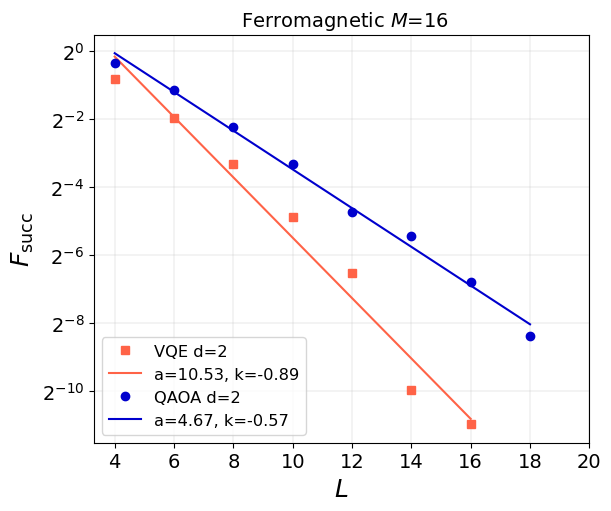

In [8]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

shots = 16
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["tomato", "red"]

#dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
dat_qaoa = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 1) & (ferro_df['algo'] == "qaoa")]
dat_vqe = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 1) & (ferro_df['algo'] == "vqe")]

popt1, _ = optimize.curve_fit(fun_lin, dat_vqe['qubits'].iloc[:-2], np.log2(dat_vqe['p_succ'].iloc[:-2]))
popt2, _ = optimize.curve_fit(fun_lin,  dat_qaoa['qubits'], np.log2(dat_qaoa['p_succ']))

ax.plot(dat_vqe['qubits'].iloc[:-2], dat_vqe['p_succ'].iloc[:-2], "s", label=f"VQE d={depth}", color=colors_rand[0])
ax.plot(dat_vqe['qubits'].iloc[:-2], fun_exp(dat_vqe['qubits'].iloc[:-2], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=colors_rand[0])

ax.plot(dat_qaoa['qubits'], dat_qaoa['p_succ'], "o", label=f"QAOA d={depth}", color=colors[-2])
ax.plot(dat_qaoa['qubits'], fun_exp(dat_qaoa['qubits'], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[-2])

ax.set_xticks(np.arange(ferro_df['qubits'].min(), ferro_df['qubits'].max() + 2, 2))
ax.set_yscale("log", base=2)
ax.grid(linewidth = 0.2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")
ax.set_title(f" Ferromagnetic " + r"$M$"+f"={shots}", fontsize=14)
ax.legend(loc='lower left', fontsize='small')

plt.savefig(f"img/fig4", dpi=300)


## Figure 5


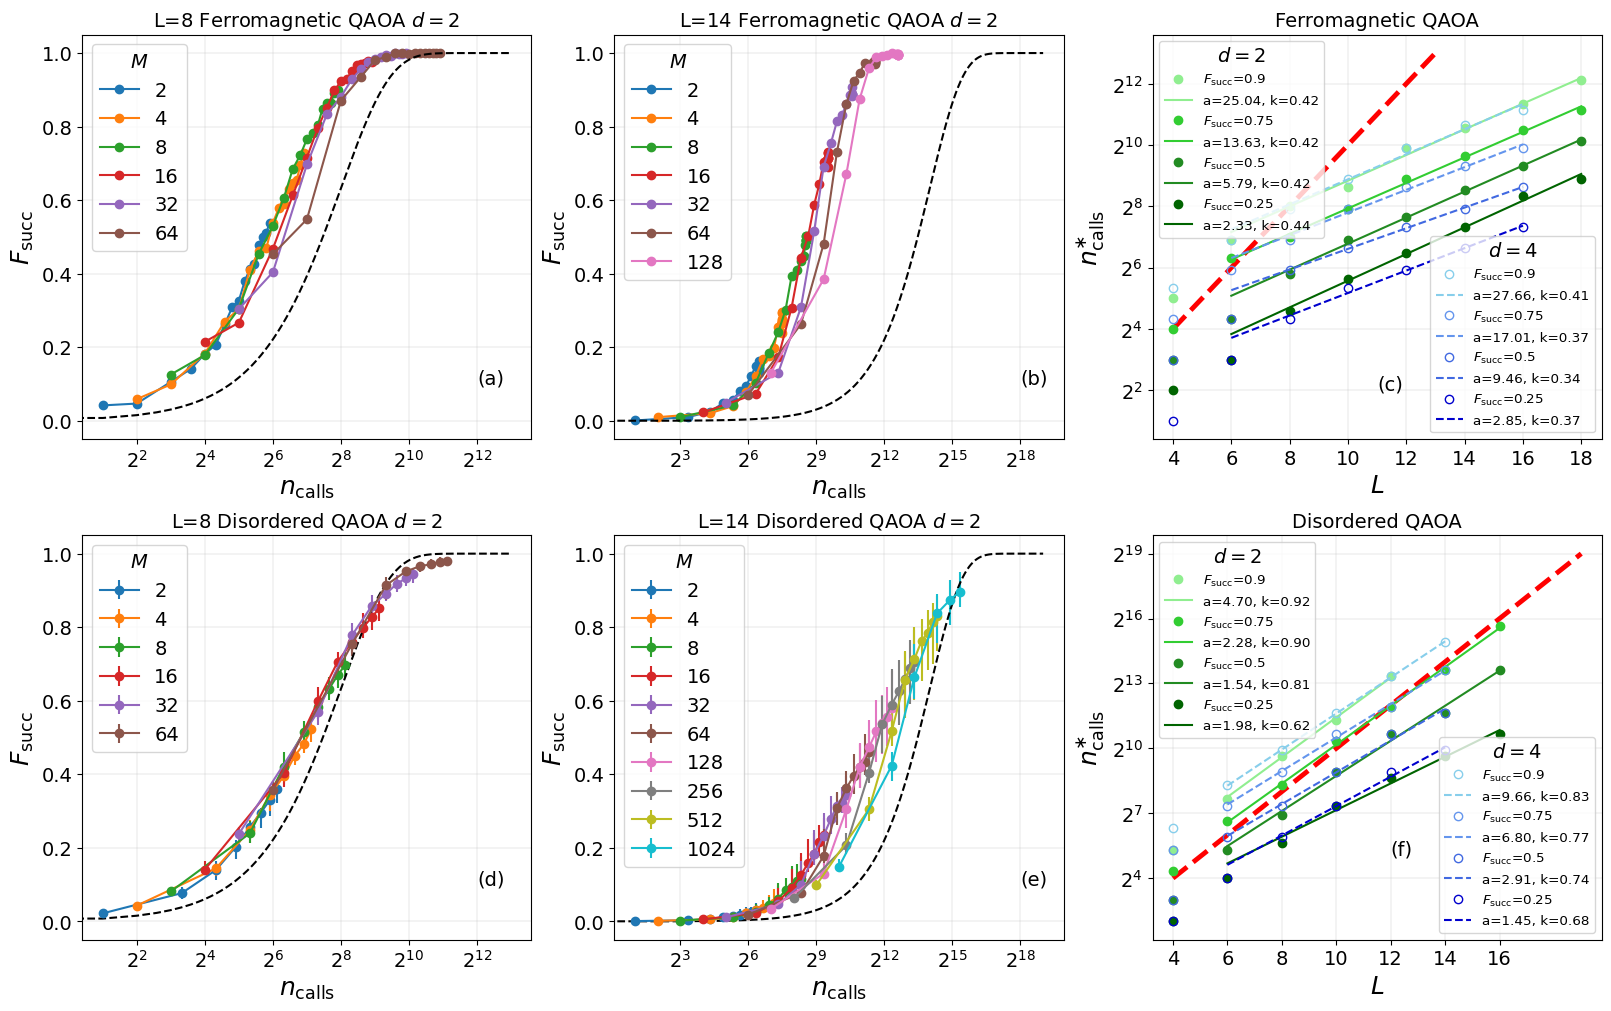

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)

for i, subplot in enumerate(subplots.ravel()):
    if i == 0:
        qubits = 8
        depth = 2
        max_shots = 128
        for shot, data in ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits) & (ferro_df['shots'] < max_shots)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$', loc="upper left")
        subplot.text(2**12, 0.1, "(a)")

    if i == 1:
        qubits = 14
        depth = 2
        for shot, data in ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$')
        subplot.text(2**18, 0.1, '(b)')

    if i == 2:
        min_qubits, max_qubits = 4, 18
        min_qubits_toplot, max_qubits_toplot = 7, 19
        #qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)
        
        depth1 = 2
        depth2 = 4
        plots1, plots2 =[], []

        subplot.plot(np.arange(min_qubits, max_qubits-4), fun_exp(np.arange(min_qubits, max_qubits-4), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth1)]
            data2 = ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth2)]
    
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            
            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][2:], np.log2(gt_p1['t'][2:]))
            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][2:], np.log2(gt_p2['t'][2:]))

            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=colors[j+5], fillstyle='none')
            plots2.append(plot2)

            plot1,  = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots1.append(plot1)
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))
        subplot.set_title("Ferromagnetic QAOA", fontsize=14)

        first_legend = subplot.legend(handles=plots1, title=r"$d=$"+f"{depth1}", loc='upper left', fontsize="x-small")
        subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='lower right', title=r"$d=$"+f"{depth2}", fontsize="x-small")

        subplot.grid(linewidth = 0.2)
       
        subplot.text(11, 2**2, '(c)')

    if i == 3:
        depth = 2
        qubits = 8
        for shot, data in spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth) & (spinglass_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data[data['seed'] == 1]['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data.groupby(['iter'])['p_succ'].median()
            error = [
                (data.groupby(['iter'])['p_succ'].median() - data.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
                (data.groupby(['iter'])['p_succ'].quantile(0.75) - data.groupby(['iter'])['p_succ'].median()).tolist(),
                ]
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
            #subplot.fill_between(x_axes, data.groupby(['iter'])['p_succ'].quantile(0.95), data.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title(f"L={qubits} Disordered " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$')

        subplot.text(2**12, 0.1, '(d)')

    if i == 4:
        qubits = 14
        depth = 2

        for shot, data in spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth) & (spinglass_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data[data['seed'] == 1]['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data.groupby(['iter'])['p_succ'].median()
            error = [
                (data.groupby(['iter'])['p_succ'].median() - data.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
                (data.groupby(['iter'])['p_succ'].quantile(0.75) - data.groupby(['iter'])['p_succ'].median()).tolist(),
                ]
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
            #subplot.fill_between(x_axes, data.groupby(['iter'])['p_succ'].quantile(0.95), data.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title(f"L={qubits} Disordered " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'$M$')

        subplot.text(2**18, 0.1, '(e)')

    if i == 5:
        min_qubits, max_qubits = 4, 16
        min_qubits_toplot, max_qubits_toplot = 7, 19
        #qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

        depth1 = 2
        depth2 = 4
        plots1, plots2 = [], []
        
        subplot.plot(np.arange(min_qubits, max_qubits_toplot+1), fun_exp(np.arange(min_qubits, max_qubits_toplot+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            median_for_seed1 = spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth1) & (spinglass_df['qubits'] >= min_qubits) & (spinglass_df['qubits'] <= max_qubits)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
            median_for_seed2 = spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth2) & (spinglass_df['qubits'] >= min_qubits)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
            
            gt_p1 = median_for_seed1[median_for_seed1['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = median_for_seed2[median_for_seed2['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][2:], np.log2(gt_p1['t'][2:]))
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)

            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][2:], np.log2(gt_p2['t'][2:]))
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))
        subplot.set_title("Disordered QAOA", fontsize=14)

        first_legend = subplot.legend(handles=plots1, title=r"$d=$"+f"{depth1}", loc='upper left', fontsize="x-small")
        subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='lower right', title=r"$d=$"+f"{depth2}", fontsize="x-small")

        subplot.grid(linewidth = 0.2)
       
        subplot.text(12, 2**5.1, '(f)')

plt.savefig("img/fig5.png", dpi=300)


## Figure 6


In [10]:
qaoa_exact_grad = np.asarray([[-0.01704544, -0.15670963,  2.98319146, 2.96817927,], 
             [-0.01785928, -0.16128583,  3.03208532,  3.00683123,], 
            [-0.01786739, -0.16133196,  3.03257763,  3.00722008,], 
            [-0.01786747, -0.16133242, 3.03258255,  3.00722396,],
            [-0.01786747, -0.16133243,  3.0325826,   3.007224,],]
            )
qaoa_m2_grad = np.asarray([[[-0.62070428,  0.01591549,  0.30239439,  0.30239439,],[ 0.63661977, -0.62070428, -0.31830989,  0.01591549,],[ 0.31830989,  0.30239439, -0.03183099, -0.04774648,]],
                           [[ 0.,    -1.5,    1.025, -0.55,], [ 0.6,  -0.9,   0.05,  1.05], [-0.975,  1.,     0.075,  0.55, ]],
                           [[-0.63333333, -0.63333333, -0.56666667, 0.7], [ 0., -0.7, 0.7, 3.46666667], [ 0., -0.7, 0.73333333, 1.83333333],],
                           [[1.,   0.9,  3.15, 1.95,], [-1.,   -0.75,  0.95,  0.,], [-0.95, -3.05, -0.1,   4.15,]],
                           [[-1.41666667, 1.66666667, 8.25, 5.], [-3.41666667, -1.83333333, 1.66666667, 5.08333333], [-1.66666667, 3.41666667, 3.41666667, -0.16666667,]],
                           [[-4.875,  5., -0.125,  0.125,], [2.125, 2.375, 2.625, 7.5,], [-2.5, -2.125, 4.5, 5.125]], 
                           [[ 0.25, -5.,   19.75, -5.25,], [ 0.,   -4.75, 15.25,  5.,], [ 0.75,  5.25, -5., 5.25,]], 
                           #[[ 10.,  -10.,   31.,   -0.5,], [10.5, 10.5, -9.5, 10.5,], [-10.5,  -9.5, -10., -9.5,]]
                           ]
                           )
qaoa_m4_grad = np.asarray(
    [
    [[0.01591549,  0.48542258, -0.29443664, -0.33422538],[-0.31830989,  0.47746483,  0.31035214,  0.18302818],[-0.30239439,  0., -0.17507044, -0.31830989], [0.00795775, -0.1511972,   0.46154933,  0.32626763,],],
    [[0.475, 1.05,  0.05,  1.475,],[-1., -0.575,  0.9, 1,], [0.025, -0.55, 0.025,  0.975,], [-0.975,  0.575,  0.5, 0.925,],],
    [[-1.25, 0.31666667, 0.38333333, 1.75,], [0.05, 0.1, 0.7, 2.35,], [-0.3, -0.1, 1.1, 1.68333333,], [0.36666667, -1.71666667, 0.28333333, 0.56666667,],],
    [[-1.95, 3.9, 4.05,  2.15,], [ 2., -3.1, 0.95, 2.1,], [-1.05,  2.9, 2.1,  1.95,], [ 0.95, -1.,  3.,  2.15,],],
    [[-1.75, 1.70833333, 0.83333333, 2.58333333,], [-1.66666667, 3.375, 1.79166667, 0.95833333,], [0.95833333, 4.125, 1.70833333, 4.08333333,], [-8.75000000e-01, -1.85037171e-16, 1.58333333e+00, 2.54166667e+00,],],
    [[-8.9375, -1.125,  -1.3125,  3.5625,], [-2.4375, -5.,  -2.375,  0.0625,], [4.9375, 2.5, 2.5, 1.4375,], [3.75,-4.5625, 2.75, 2.5,],], 
    [[-1.05,2.9,2.1, 1.95], [-4.5,  -5.,   -0.25,  0.,], [5.25, 0.5,  0.,  5.25,], [ 0., 4.75, 20.5, -4.75,],],
    ]
    )
qaoa_m16_grad = np.asarray([[[-0.2327641, 0.10742959, 0.08355635, 0.01193662,], [-0.35014087, -0.0755986, -0.06764085, 0.15915494,], [0.00198944, 0.03580986, 0.29045777, -0.07758803,], [0.23077467, 0.23077467, 0.45359159, -0.36804581,],],
                           [[-0.58125, -0.04375, 0.296875, 1.078125,], [-0.309375, 0.034375, 0.378125, 0.14375, ], [-0.178125, -0.4125,    0.26875,   0.675,],  [0.33125,  0.15625,  0.3375,   0.540625,],],
                           [[1.01666667, -0.39583333, 1.2, 1.44583333,],[0.05416667, 0.37916667, 0.7875, 1.47083333,],[0.225, 0.04583333, 0.775, 1.09166667,], [-0.35416667, -0.87083333, 0.8375, 1.775,],],
                           [[ 0.23125, -0.15, 2.55625,  1.76875,], [ 0.3875, -1.025,   1.7625,  2.7375,],  [-0.95,  -0.35625,  2.48125,  2.91875,], [-0.40625, -0.66875,  1.48125,  2.53125,],],
                           [[0.20833333, 1.69791667, 1.83333333, 1.42708333,], [0.05208333, 0.82291667, 3.13541667, 1.52083333,], [-0.64583333, -0.35416667, 1.20833333, 3.28125,], [-0.46875, -0.91666667, 2.29166667, 3.20833333]],
                           [[ 1.234375, -1.28125,   3.46875,   3.5,],  [-0.625, -0.65625,   3.375,     3.765625,], [-2.765625,  0.,  1.90625,   3.453125,],  [-2.765625,  0.,        1.90625,   3.453125,],],
                           [[-3.8125,  -3.78125,  1.3125,   6.71875,],  [-2.5,   -2.4375,   6.15625,  0.71875,],  [ 3.6875,  -1.34375,  5.,   5.0625,],  [3.1875,  0.625,   4.96875, 3.84375,],],
                           #[[ 2.5625, -0.9375, -1.3125,  0.1875], [ 1.375, -1.,     2.625,  7.625,], [6.3125, 2.5,    2.25,   2.5625,], [6.4375, -3.9375,  2.25,    4.,],],
                           ]
                           )
qaoa_m32_grad = np.asarray([[[-0.18999121, -0.02486796, 0.1511972, 0.0865405,], [-0.01293134, 0.07360916, -0.23674298, 0.01691021,], [0.25265847, -0.05669895, 0.05073064, -0.19198065,], [-0.04376761, -0.12036093, 0.12632924, -0.08156691,],],                       
                           [[0.028125, 0.0640625, 0.7171875, 0.8015625], [0.0015625, 0.109375, 0.2703125, 0.4921875], [-0.3515625, 0.0171875, 0.4375, 0.8546875], [-0.10625, -0.0828125, 0.8625, 0.715625,],],
                           [[-0.0234375, 0.23242187, 1.08984375, 1.1796875,], [-0.08984375, 0.08984375, 1.11523438, 1.23632812], [0.24609375, -0.02929688, 1.05664062, 1.24804688], [-0.16601562, 0.0625, 1.46484375, 1.28515625,],],
                           [[0.240625, -0.49375, 2.20625, 3.128125], [1.053125, -0.19375, 2.184375, 1.75625,], [-0.734375, -0.165625, 2.85625, 1.846875,], [0.653125, 1.03125, 1.86875, 2.278125,],],
                           [[ 0.51041667, -0.3125, 2.36458333, 3.453125,], [-0.36458333, -0.55208333,  2.66666667,  2.94270833,], [ 0., -1.046875, 1.58854167,  2.625,], [1.06770833, 0.03645833, 2.68229167, 1.33333333,],],
                           [[1.265625, -1.3515625, 2.8203125, 3.5,], [0.9140625, -1.3984375, 3.421875, 3.1875,], [0.171875, -0.9765625, 2.984375, 2.21875,], [-0.3203125, 0.140625, 2.984375, 2.40625,],],
                           [[1.1875, -2.671875, 3.15625, 1.15625,], [-1.3125, -0.4375, 3.1875, 1.796875], [ 1.15625, -1.03125, 6.203125, 2.734375,], [0.921875, -0.1875, 3.21875, 1.9375,],],
                           #[[1.53125, 0.640625, 2.3125, 2.1875,], [0.921875, 1.71875, 4.34375, 2.21875,], [-0.71875, -0.625, -0.359375, 5.328125], [-1.265625, -0.59375, 5.03125, 4.46875,],],		
                           ]
                           )
eps = [math.pi/2,1,0.75,0.5,0.3,0.2,0.1]

In [11]:
depth1 = 2
depth2 = 2
algo = 'qaoa' 

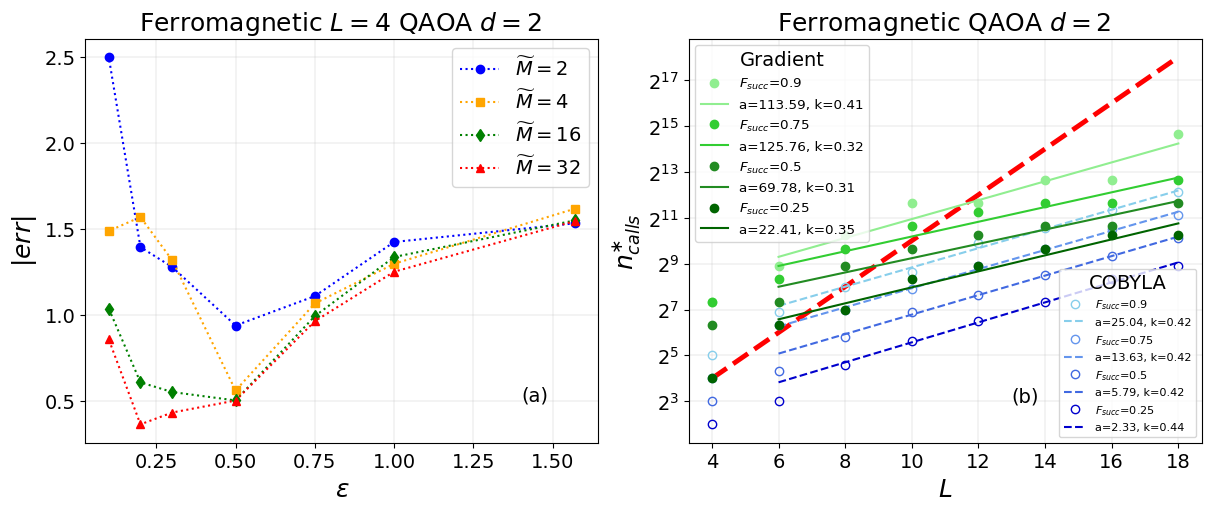

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(12,5))
subplots = fig.subplots(1,2)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):
    if i==0:
        noise_qaoa = [qaoa_m2_grad, qaoa_m4_grad, qaoa_m16_grad, qaoa_m32_grad]
        shots=[2,4,16,32]
        symbols=["o", "s", "d", "^"]
        colors=["b","orange","g","r"]

        for i,s in enumerate(noise_qaoa):
            abs_err = np.abs((s.mean(1) - qaoa_exact_grad.mean(0)))
            # error = [
            #     (np.median(abs_err, 1) - np.quantile(abs_err, 0.25, 1)).tolist(),
            #     (np.quantile(abs_err, 0.75, 1) - np.median(abs_err, 1)).tolist(),
            #     ]
            #subplot.errorbar(eps, np.median(abs_err, 1), yerr=error, marker=symbols[i], linestyle='dotted', label=r"$\widetilde{M}=$" f"{shots[i]}", color=colors[i])
            subplot.plot(eps, np.mean(abs_err, 1), marker=symbols[i], linestyle='dotted', label=r"$\widetilde{M}=$" f"{shots[i]}", color=colors[i])

        subplot.set_xlabel(r"$\varepsilon$")
        subplot.set_ylabel(r"$|err|$")

        subplot.grid(linewidth = 0.2)

        subplot.set_title("Ferromagnetic" + r" $L=4$" + f" {algo.upper()} " + r"$d=$"+f"{depth1} ")
       
        subplot.text(1.4, 0.5, '(a)')
        
        subplot.legend()

    elif i==1:
        min_qubits, max_qubits = 4, 18
        min_qubits_toplot, max_qubits_toplot = 4, 19
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

        subplot.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        plots1, plots2 = [], []

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = datagrad_eps05[(datagrad_eps05['algo'] == algo) & (datagrad_eps05['circ_depth'] == depth1) & (datagrad_eps05['qubits'] >= min_qubits) & (datagrad_eps05['qubits'] <= max_qubits)]
            data2 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth2) & (ferro_df['qubits'] >= min_qubits) ]

            # update t for gradient
            if algo == "vqe":
                data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*data1.loc[:,'qubits']*depth1 #vqe
            elif algo == "qaoa": 
                data1.loc[:,'t'] = 2*data1.loc[:,'iter']*data1.loc[:,'shots']*2*depth1 #qaoa
            else:
                print(f"Not implemented algo {algo}")
                break
            
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][1:], np.log2(gt_p1['t'])[1:])
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)

            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][2:], np.log2(gt_p2['t'])[2:])
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)

        subplot.set_ylabel(r"$n^{\ast}_{calls}$")
        subplot.set_xlabel(r"$L$")
        
        subplot.grid(linewidth = 0.2)

        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        first_legend = subplot.legend(handles=plots1, title=r"Gradient", loc='upper left', fontsize="x-small")
        subplot1 = plt.gca().add_artist(first_legend)
        subplot.legend(handles=plots2, loc='lower right', title=r"COBYLA", fontsize="xx-small")
        subplot.text(13, 8, '(b)')

        subplot.set_title(f"Ferromagnetic {algo.upper()} " + r"$d=$"+f"{depth1} ")

plt.savefig("img/fig6.png", dpi=300)


## Figure 7


In [13]:
depths = [2,4]
maxiter_d2 = 40
maxiter_d4 = 60
maxiter_rand = 20

/tmp/ipykernel_195593/3837214490.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, no opt., random init.", color=colors_rand[k % 2])
/tmp/ipykernel_195593/3837214490.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, rando

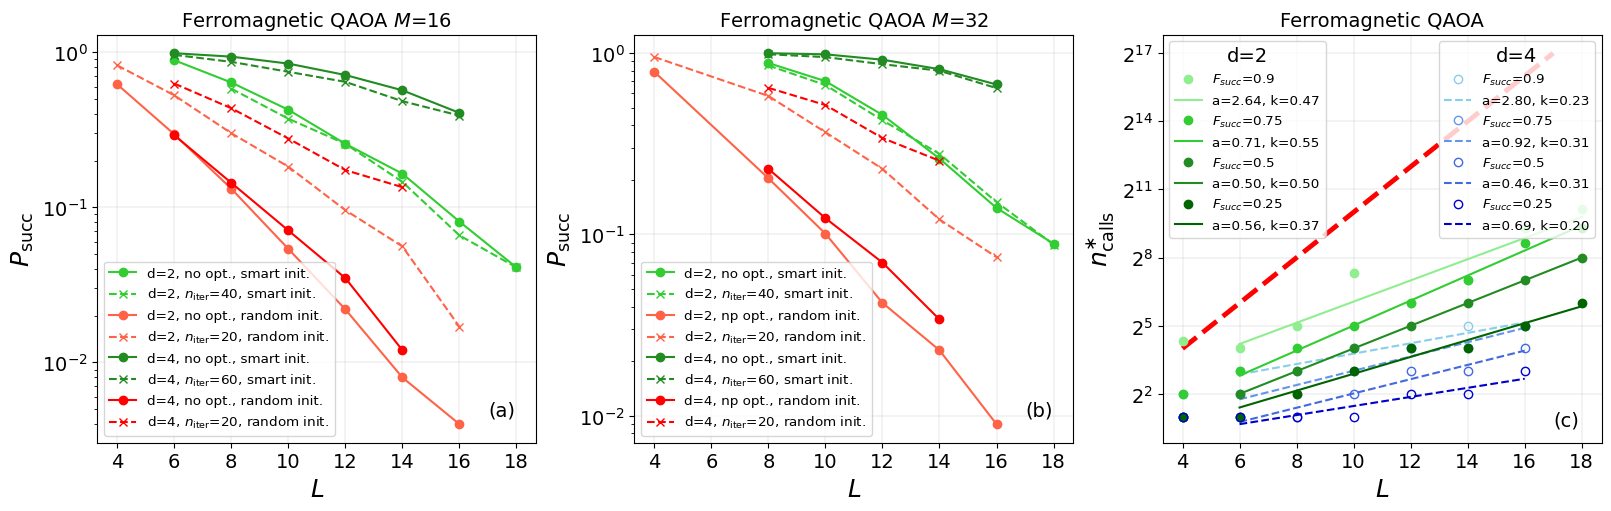

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,3)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):
    if i==0:
        shots = 16
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        colors_rand = ["tomato", "red"]
        for k, depth in enumerate(depths):
            if ((depth == 2) or (depth == 4)):
                dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
                dat_rand = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 1) & (ferro_df['algo'] == "qaoa")]

                dat = dat[dat["p_succ_final"]!=0]

                #popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][1:], np.log2(dat['p_succ'][1:]))
                subplot.plot(dat['qubits'], dat['p_succ_final'], "-o", label=f"d={depth}, no opt., smart init.", color=colors[k+1])
                #subplot.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])

                maxiter = maxiter_d2 if depth==2 else maxiter_d4
                dat_after_opt = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == maxiter)]
                dat_after_opt_rand = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == maxiter_rand) & (ferro_df['algo'] == "qaoa")]

                #popt2, _ = optimize.curve_fit(fun_lin,  dat_after_opt['qubits'][1:], np.log2(dat_after_opt['p_succ_final'][1:]))
                subplot.plot(dat_after_opt['qubits'], dat_after_opt['p_succ_final'], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}, smart init.", color=colors[k+1])

                subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, no opt., random init.", color=colors_rand[k % 2])
                subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, random init.", color=colors_rand[k % 2])
                #subplot.plot(dat_after_opt['qubits'][1:], fun_exp(dat_after_opt['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k+1])
        subplot.set_xticks(np.arange(data_linopt['qubits'].min(), data_linopt['qubits'].max() + 2, 2))
        subplot.set_yscale("log", base=10)
        subplot.grid(linewidth = 0.2)
        subplot.set_xlabel(r"$L$")
        subplot.set_ylabel(r"$P_{\mathrm{succ}}$")
        subplot.set_title(r"Ferromagnetic QAOA $M$"+f"={shots}", fontsize=14)
        subplot.legend(loc='lower left', fontsize='x-small')
        subplot.text(17, 0.0045, '(a)')

    if i==1:
        shots = 32
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        colors_rand = ["tomato", "red"]
        for k, depth in enumerate(depths):
            if ((depth == 2) or (depth == 4)):
                dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
                dat_rand = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 1) & (ferro_df['algo'] == "qaoa")]

                dat = dat[dat["p_succ_final"]!=0]

                #popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][1:], np.log2(dat['p_succ'][1:]))
                subplot.plot(dat['qubits'], dat['p_succ_final'], "-o", label=f"d={depth}, no opt., smart init.", color=colors[k+1])
                #subplot.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])

                maxiter = maxiter_d2 if depth==2 else maxiter_d4
                dat_after_opt = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == maxiter)]
                dat_after_opt_rand = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == maxiter_rand) & (ferro_df['algo'] == "qaoa")]

                #popt2, _ = optimize.curve_fit(fun_lin,  dat_after_opt['qubits'][1:], np.log2(dat_after_opt['p_succ_final'][1:]))
                subplot.plot(dat_after_opt['qubits'], dat_after_opt['p_succ_final'], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}, smart init.", color=colors[k+1])

                subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, np opt., random init.", color=colors_rand[k % 2])
                subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, random init.", color=colors_rand[k % 2])
                #subplot.plot(dat_after_opt['qubits'][1:], fun_exp(dat_after_opt['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k+1])
        subplot.set_xticks(np.arange(data_linopt['qubits'].min(), data_linopt['qubits'].max() + 2, 2))
        subplot.set_yscale("log", base=10)
        subplot.grid(linewidth = 0.2)
        subplot.set_xlabel(r"$L$")
        subplot.set_ylabel(r"$P_{\mathrm{succ}}$")
        subplot.set_title(r"Ferromagnetic QAOA $M$"+f"={shots}", fontsize=14)
        subplot.legend(loc='lower left', fontsize='x-small')
        subplot.text(17, 10**-2, '(b)')

    if i==2:
        min_qubits, max_qubits = 4, 18
        min_qubits_toplot, max_qubits_toplot = 4, 18
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)
        depth1 = 2
        depth2 = 4
        algo = 'qaoa' 
        subplot.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")
        plots1, plots2 = [], []
        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth1) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
            data2 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth2) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][2:], np.log2(gt_p1['t'][2:]))
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)
            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][1:], np.log2(gt_p2['t'][1:]))
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)

        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")

        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        subplot.grid(linewidth = 0.2)

        first_legend = subplot.legend(handles=plots1, title=f"d={depth1}", loc='upper left', fontsize="x-small")
        subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='upper right', title=f"d={depth2}", fontsize="x-small")
        subplot.set_title("Ferromagnetic QAOA", fontsize=14)
        subplot.text(17, 1.5, '(c)')

plt.savefig(f"img/fig7", dpi=300)


## Figure 8


In [15]:
depth = 2
maxiters = [10, 30]
shots = 16

/tmp/ipykernel_195593/1792225322.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors_rand[-1], label=f"Random init., no opt.")
/tmp/ipykernel_195593/1792225322.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors[-1], label=f"Smart init., no opt.")


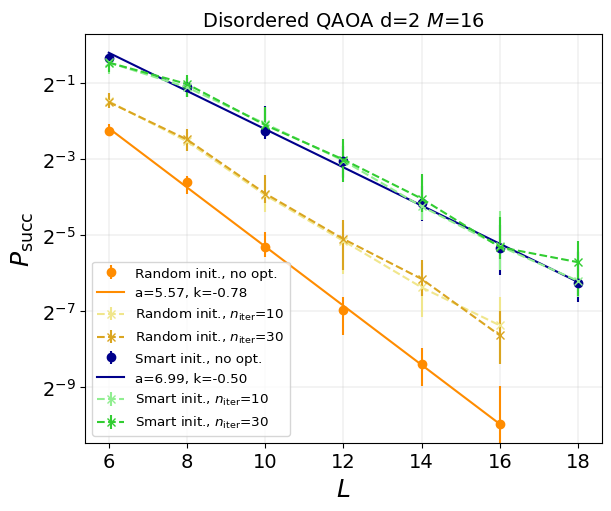

In [16]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["khaki", "goldenrod", "darkgoldenrod", "orange", "darkorange"]

dat_randinit = spinglass_df[(spinglass_df['shots'] == shots) & (spinglass_df['circ_depth'] == depth) & (spinglass_df['iter'] == 1) & (spinglass_df['algo'] == "qaoa")]
dat_linearinit = data_linopt_rand[(data_linopt_rand['shots'] == shots) & (data_linopt_rand['circ_depth'] == depth) & (data_linopt_rand['iter'] == 1) & (data_linopt_rand['algo'] == "qaoa")]


x_axes = dat_randinit[dat_randinit['seed'] == 1]['qubits'] #*dat_randinit[dat_randinit['seed'] == 1]["circ_depth"]
y_axes = dat_randinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_randinit.groupby(['qubits'])['p_succ_final'].median() - dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors_rand[-1], label=f"Random init., no opt.")
popt1, _ = optimize.curve_fit(fun_lin, x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=colors_rand[-1])

for k, maxiter in enumerate(maxiters):
    dat_randinit_final = spinglass_df[(spinglass_df['shots'] == shots) & (spinglass_df['circ_depth'] == depth) & (spinglass_df['iter'] == maxiter) & (spinglass_df['algo'] == "qaoa")]

    x_axes = dat_randinit_final[dat_randinit_final['seed'] == 1]['qubits'] #*dat_randinit_final[dat_randinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()
    error = [
            (dat_randinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
            (dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors_rand[k], label=f"Random init.," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}")

x_axes = dat_linearinit[dat_linearinit['seed'] == 1]['qubits'] #*dat_linearinit[dat_linearinit['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors[-1], label=f"Smart init., no opt.")
popt2, _ = optimize.curve_fit(fun_lin,  x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[-1])

for k, maxiter in enumerate(maxiters):
    dat_linearinit_final = data_linopt_rand[(data_linopt_rand['shots'] == shots) & (data_linopt_rand['circ_depth'] == depth) & (data_linopt_rand['iter'] == maxiter) & (data_linopt_rand['algo'] == "qaoa")]

    x_axes = dat_linearinit_final[dat_linearinit_final['seed'] == 1]['qubits'] #*dat_linearinit_final[dat_linearinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()
    error = [
            (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
            (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors[k], label=f"Smart init.," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}")


ax.set_xticks(np.arange(dat_linearinit['qubits'].min(), dat_linearinit['qubits'].max() + 2, 2))
ax.set_yscale("log", base=2)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$P_{\mathrm{succ}}$")

ax.set_title(f"Disordered QAOA d=2" + r" $M$"+f"={shots}", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,4,5,1,6,7]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', fontsize='x-small')
#ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/fig8.png", dpi=300)


## Figure 9


In [17]:
depths = [2,4,8,16,32]
algo = 'qaoa'
which_prob = 'p_succ_final'

TOFIX -> it should be the same dataset

In [18]:
data_lininit_spinglass = pd.read_csv("data_spinglass_iter1.csv", index_col=0)
data_lininit_ferro = pd.read_csv("data_opt16shots.csv", index_col=0)

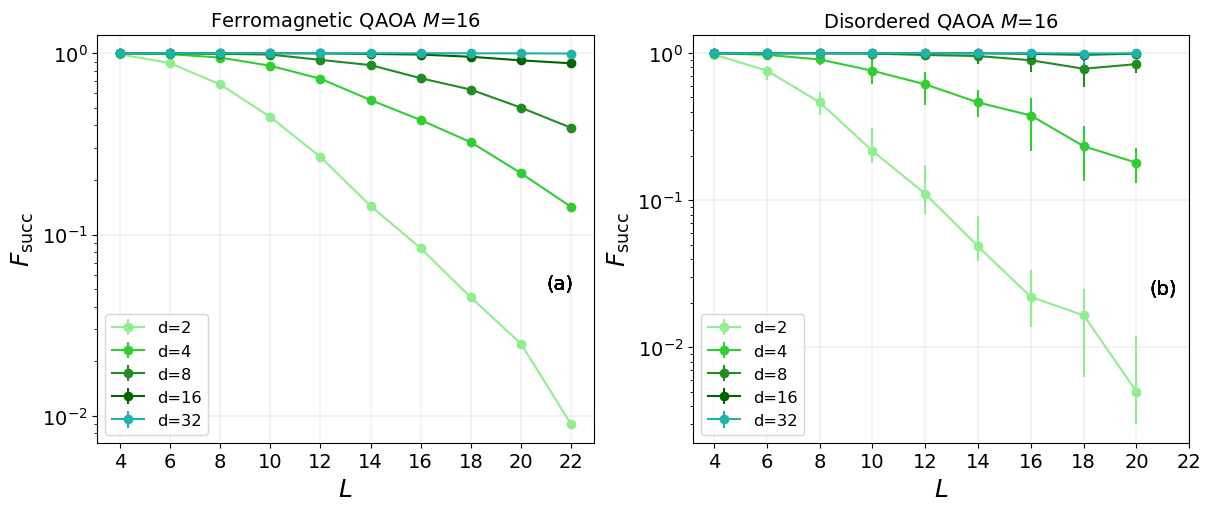

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(12,5))
#fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,2)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):

    colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']

    if i==0:
        for k, depth in enumerate(depths):
            dat = data_lininit_ferro[(data_lininit_ferro['algo'] == algo) & (data_lininit_ferro['circ_depth'] == depth)]
            dat = dat[dat[which_prob]!=0]

            x_axes = dat['qubits'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = dat.groupby(['qubits'])[which_prob].median()
            error = [
                (y_axes - dat.groupby(['qubits'])[which_prob].quantile(0.25)).tolist(),
                (dat.groupby(['qubits'])[which_prob].quantile(0.75) - y_axes).tolist(),
                ]

            #popt1, _ = optimize.curve_fit(fun_lin,  x_axes[2:], np.log2(y_axes[2:]))
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"d={depth}", color=colors[k])
            subplot.set_title(f"Ferromagnetic QAOA " + r"$M$"+f"=16", fontsize=14)
            subplot.text(21, 0.05, '(a)')



    if i==1:
        for k, depth in enumerate(depths):
            dat = data_lininit_spinglass[(data_lininit_spinglass['algo'] == algo) & (data_lininit_spinglass['circ_depth'] == depth)]
            dat = dat[dat[which_prob]!=0]

            x_axes = dat[dat['seed'] == 1]['qubits']
            y_axes = dat.groupby(['qubits'])[which_prob].median()
            error = [
                (y_axes - dat.groupby(['qubits'])[which_prob].quantile(0.25)).tolist(),
                (dat.groupby(['qubits'])[which_prob].quantile(0.75) - y_axes).tolist(),
                ]

            #popt2, _ = optimize.curve_fit(fun_lin,  x_axes[2:], np.log2(y_axes[2:]))
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"d={depth}", color=colors[k])
            subplot.set_title(f"Disordered QAOA " + r"$M$"+f"=16", fontsize=14)
            subplot.text(20.5, 0.023, '(b)')


    subplot.set_xticks(np.arange(data_lininit_spinglass['qubits'].min(), data_lininit_spinglass['qubits'].max() + 2, 2))
    subplot.set_yscale("log", base=10)

    subplot.grid(linewidth = 0.2)

    subplot.set_xlabel(r"$L$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.legend(loc='lower left', fontsize='small')

plt.savefig("img/fig9.png", dpi=300)